In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [30]:
words = open('names.txt').read().splitlines()
chars = ['.'] + sorted(set(''.join(words)))
vocab_size = len(chars)
itos = {i:s for i, s in enumerate(chars)}
stoi = {s:i for i, s in itos.items()}

In [31]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [96]:
n_embd = 10
n_hidden = 100

torch.manual_seed(42)
E = torch.randn(vocab_size, n_embd)

W1 = torch.randn(block_size*n_embd, n_hidden) * (5/3) * (1/(block_size*n_embd)**0.5)
b1 = torch.randn(1, n_hidden) * 0.001
W2 = torch.randn(n_hidden, vocab_size) * (5/3) * (1/(n_hidden)**0.5)
b2 = torch.randn(1, vocab_size) * 0.001

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

parameters = [E, W1, b1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True

In [97]:
torch.manual_seed(42)
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = E[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
  hpreact = bn_gain * hpreact + bn_bias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # plt.hist(hpreact.view(-1).tolist(), bins=50, density=True)
  # plt.hist(h.view(-1).tolist(), bins=50, density=True)
  # plt.show()

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d} Loss: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break



      0/ 100000 Loss: 3.8400
  10000/ 100000 Loss: 2.2577
  20000/ 100000 Loss: 2.4169
  30000/ 100000 Loss: 2.2778
  40000/ 100000 Loss: 2.0795
  50000/ 100000 Loss: 2.4664
  60000/ 100000 Loss: 2.3178
  70000/ 100000 Loss: 2.4660
  80000/ 100000 Loss: 1.9608
  90000/ 100000 Loss: 2.1771


In [94]:
@torch.no_grad()
def find_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    # forward pass
    emb = E[X] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    hpreact = bn_gain * hpreact + bn_bias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y) # loss function
    return loss.item()

In [98]:
print('Train loss:', find_loss('train'))
print('Val loss:', find_loss('val'))

Train loss: 2.1595239639282227
Val loss: 2.181779623031616


- Train loss: 2.1500165462493896
- Val loss: 2.1906745433807373

---

- Train loss: 2.1595239639282227
- Val loss: 2.181779623031616

In [44]:
torch.manual_seed(42)
emb = nn.Embedding(vocab_size, n_embd)
fc1 = nn.Linear(block_size*n_embd, n_hidden)
fc2 = nn.Linear(n_hidden, vocab_size)

params = [
    list(emb.parameters()),
    list(fc1.parameters()),
    list(fc2.parameters())
]

In [45]:
torch.manual_seed(42)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  e = emb(Xb) # embed the characters into vectors
  embcat = e.view(e.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = fc1(embcat) # hidden layer pre-activation
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = fc2(h)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for param in params:
    for p in param:
      p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for param in params:
    for p in param:
      p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.2763


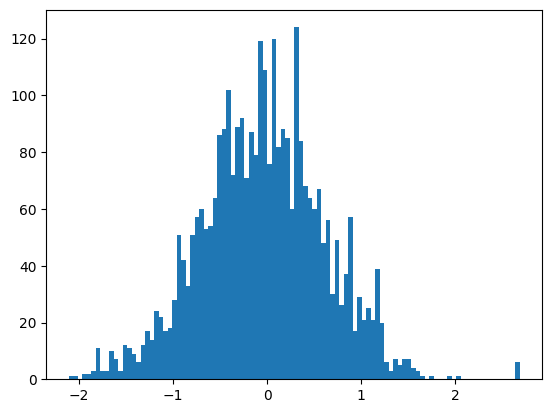

In [46]:
plt.hist(hpreact.view(-1).tolist(), bins=100)
plt.show()

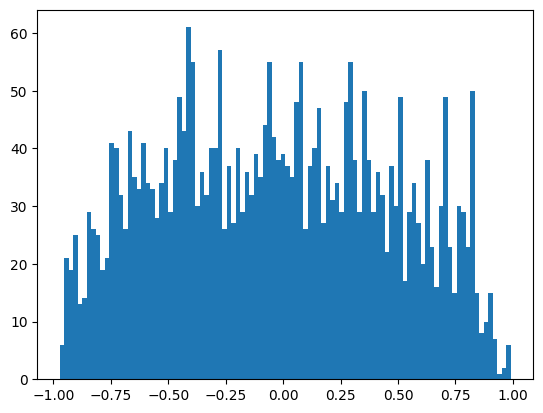

In [47]:
plt.hist(h.view(-1).tolist(), bins=100)
plt.show()

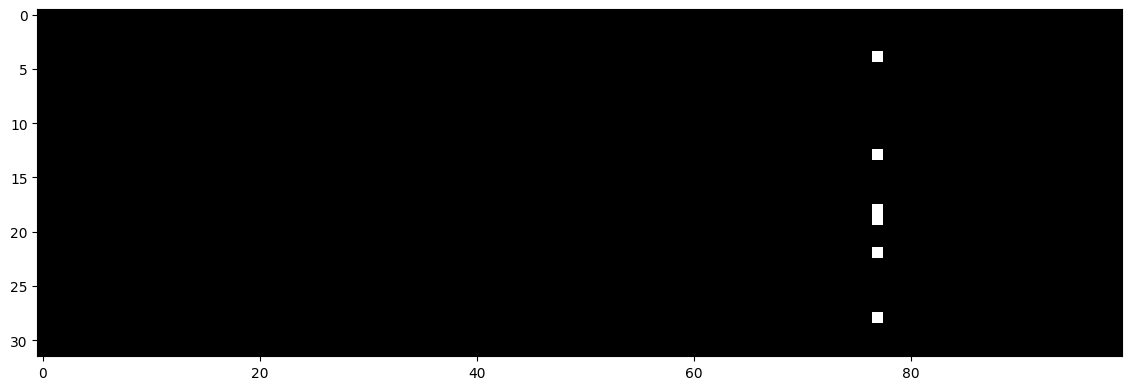

In [48]:
plt.figure(figsize=(14, 6))
plt.imshow(h.abs() > 0.99, cmap='gray')
# plt.axis('off')
plt.show()

In [3]:
import torch
import matplotlib.pyplot as plt

tensor(-0.0044) tensor(0.9962)
tensor(0.0009) tensor(0.9566)


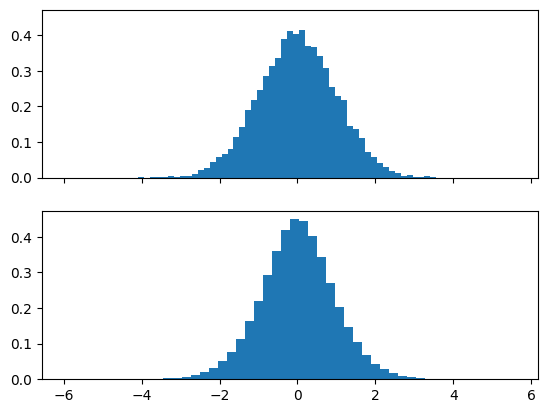

In [10]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.hist(x.view(-1), 50, density=True)
ax2.hist(y.view(-1), 50, density=True)
plt.show()